# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Kellie Leopold [GitHub Link](https://github.com/kjleopold/article-summarizer)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

In [106]:
# Create and activate a Python virtual environment. 
# Before starting the project, try all these imports FIRST
# Address any errors you get running this code cell 
# by installing the necessary packages into your active Python environment.
# Try to resolve issues using your materials and the web.
# If that doesn't work, ask for help in the discussion forums.
# You can't complete the exercises until you import these - start early! 
# We also import pickle and Counter (included in the Python Standard Library).

from collections import Counter
import pickle
import requests
import spacy
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

!pip list

print('All prereqs installed.')

Package                   Version
------------------------- --------------
annotated-types           0.7.0
anyio                     4.10.0
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
blis                      1.3.0
catalogue                 2.0.10
certifi                   2025.8.3
cffi                      1.17.1
charset-normalizer        3.4.2
click                     8.2.1
cloudpathlib              0.21.1
colorama                  0.4.6
comm                      0.2.3
confection                0.1.5
contourpy                 1.3.3
cycler                    0.12.1
cymem                     2.0.11
debugpy                   1.8.15
decorator                 5.2.1
defusedxml                0.7.1
en_core_web_sm            3.8.0
et_xmlfile    

#### 1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [107]:
import requests
import pickle
from get_spotify_token import get_token

# Get access token
ACCESS_TOKEN = get_token()

# Manually insert playlist ID
playlist_id = "2XXbR1BBAsLiaoKLbSA3WU"

# Set headers
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}"
}

# Endpoint to get tracks from the playlist
tracks_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

# Make request
response = requests.get(tracks_url, headers=headers)

# Save response as .pkl if successful
if response.status_code == 200:
    data = response.json()  # parse JSON to dict
    with open("top_hits_2000s.pkl", "wb") as f:
        pickle.dump(data, f)
    print("Tracks saved to top_hits_2000s.pkl")
else:
    print(f"Failed to get playlist tracks: {response.status_code}")
    print(response.text)

Tracks saved to top_hits_2000s.pkl


#### 2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [ ]:
import pickle
from bs4 import BeautifulSoup
from textblob import TextBlob

# Load the pickle file
with open('top_hits_2000s.pkl', 'rb') as file:
    data = pickle.load(file)

# Build a clean string with track + artist info
summary_lines = []
for i, item in enumerate(data.get('items', []), start=1):
    track = item.get('track', {})
    track_name = track.get('name', 'Unknown Track')
    artists = ", ".join(artist.get('name', 'Unknown Artist') for artist in track.get('artists', []))
    summary_lines.append(f'{i}. "{track_name}" by {artists}')

# Join into a single text block for sentiment analysis
text = "\n".join(summary_lines)

# Print a snippet of the cleaned text
print("Track List:\n")
print(text[:500] + "\n...")

# Perform sentiment analysis
blob = TextBlob(text)
polarity = blob.sentiment.polarity
num_sentences = len(blob.sentences)

# Print sentiment results
print(f"\nPolarity score: {polarity:.3f}")
print(f"Number of sentences: {num_sentences}")

Track List:

1. "Yeah! (feat. Lil Jon & Ludacris)" by USHER, Lil Jon, Ludacris
2. "Wherever You Will Go" by The Calling
3. "Where Is The Love?" by Black Eyed Peas
4. "Whenever, Wherever" by Shakira
5. "What a Girl Wants" by Christina Aguilera
6. "Unwritten" by Natasha Bedingfield
7. "Torn" by Natalie Imbruglia
8. "Toxic" by Britney Spears
9. "Thong Song" by Sisqo
10. "This Love" by Maroon 5
11. "These Words" by Natasha Bedingfield
12. "The Great Escape" by BOYS LIKE GIRLS
13. "Teardrops On My Guitar - Radio 
...

Polarity score: 0.064
Number of sentences: 113


#### 3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [ ]:
import spacy
from collections import Counter

# Load data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract all song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Join all titles into one string
text = " ".join(titles)

# Load spaCy and process the text
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

# Filter and lowercase tokens
tokens = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]

# Count token frequencies
freq = Counter(tokens)
most_common = freq.most_common(5)

# Print results
print("Top 5 most frequent tokens:")
for word, count in most_common:
    print(f"Token: '{word}' – Frequency: {count}")

Top 5 most frequent tokens:
Token: 'feat' – Frequency: 8
Token: 'love' – Frequency: 5
Token: 'girl' – Frequency: 4
Token: 'radio' – Frequency: 3
Token: 'remix' – Frequency: 3


#### 4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [110]:
# Load song data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Combine titles into one text string
text = " ".join(titles)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

# Use lemmas: lowercase, alpha only, exclude stop words
lemmas = [
    token.lemma_.lower()
    for token in doc
    if token.is_alpha and not token.is_stop
]

# Count and display top 5 most frequent lemmas
freq = Counter(lemmas)
most_common = freq.most_common(5)

print("Top 5 most frequent lemmas in song titles:")
for lemma, count in most_common:
    print(f"• Lemma: '{lemma}' – Frequency: {count}")

Top 5 most frequent lemmas in song titles:
• Lemma: 'feat' – Frequency: 8
• Lemma: 'love' – Frequency: 5
• Lemma: 'girl' – Frequency: 4
• Lemma: 'radio' – Frequency: 3
• Lemma: 'remix' – Frequency: 3


#### 5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

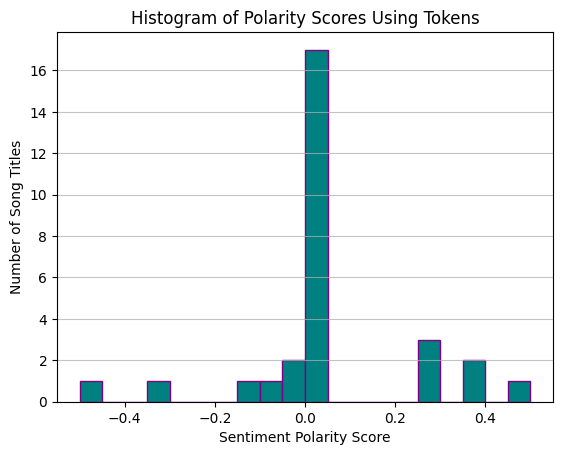

In [111]:
# Load song data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Combine titles into one text string
text = " ".join(titles)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process text
doc = nlp(text)

# Get sentiment polarity scores per song using TextBlob
sentence_scores = []
for sent in doc.sents:
    blob = TextBlob(sent.text)
    polarity = blob.sentiment.polarity  # between -1 (negative) and 1 (positive)
    sentence_scores.append(polarity)

# Plot histogram of sentence polarity scores
plt.hist(sentence_scores, bins=20, color='teal', edgecolor='purple')
plt.title('Histogram of Polarity Scores Using Tokens')
plt.xlabel('Sentiment Polarity Score')
plt.ylabel('Number of Song Titles')
plt.grid(axis='y', alpha=0.75)
plt.show()

# From the histogram, the most common range of scores seems to be around 0 (neutral to slightly positive). For song titles, this would be an expected outcome.

#### 6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

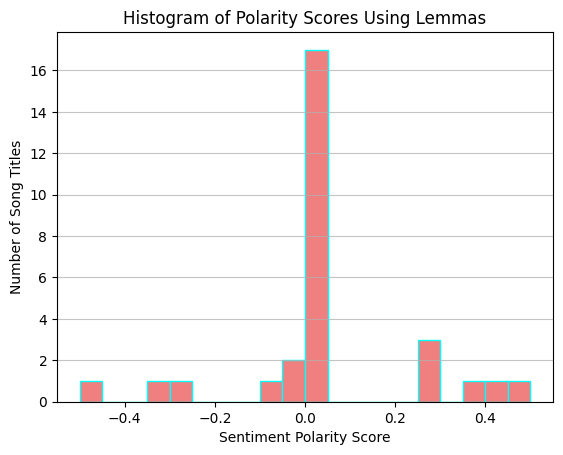

In [ ]:
# Load song data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Combine titles into one text string
text = " ".join(titles)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process the text
doc = nlp(text)

sentence_scores = []

for sent in doc.sents:
    # Extract lemmas from sentence tokens, filtering alpha and stop words
    lemmas = [token.lemma_.lower() for token in sent if token.is_alpha and not token.is_stop]
    
    # Join lemmas back into a string for sentiment analysis
    lemma_text = " ".join(lemmas)
    
    # Get polarity score of the lemma-based sentence string
    blob = TextBlob(lemma_text)
    polarity = blob.sentiment.polarity
    
    sentence_scores.append(polarity)

# Plot histogram of lemma-based sentence polarity scores
plt.hist(sentence_scores, bins=20, color='lightcoral', edgecolor='aqua')
plt.title('Histogram of Polarity Scores Using Lemmas')
plt.xlabel('Sentiment Polarity Score')
plt.ylabel('Number of Song Titles')
plt.grid(axis='y', alpha=0.75)
plt.show()

# As with question 5, the most common range of scores appears to be around 0 (neutral to slightly positive). With song titles, it is common for tokens and lemmas to be the same. 

#### 7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): 0.05
* Cutoff Score (lemmas): 0.05

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

#### 8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [113]:
import numpy as np

# Load song data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Calculate token-based sentiment polarity scores per title
sentence_scores_tokens = []

for title in titles:
    doc = nlp(title)
    tokens = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
    token_text = " ".join(tokens)
    polarity = TextBlob(token_text).sentiment.polarity
    sentence_scores_tokens.append(polarity)

# Calculate median cutoff score
median_tokens = np.median(sentence_scores_tokens)

# Filter titles with scores above the median
summary_titles_tokens = [title for title, score in zip(titles, sentence_scores_tokens) if score > median_tokens]

# Print summary as bullet points
print("Summary of positively scored song titles:\n")
print("\n".join(f"- {title}" for title in summary_titles_tokens))

Summary of positively scored song titles:

- Where Is The Love?
- What a Girl Wants
- This Love
- The Great Escape
- Smooth (feat. Rob Thomas)
- Rich Girl
- New Soul
- Love Story
- Love Song
- Live Your Life - feat. Rihanna
- Hot In Herre
- Get Busy
- Feel Good Inc.
- Drop It Like It's Hot


#### 9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [114]:
# Join the summary titles into one string
summary_text = ' '.join(summary_titles_tokens)

# Get polarity score of the whole summary
summary_polarity = TextBlob(summary_text).sentiment.polarity

# Print results
print("\nSummary polarity score:", summary_polarity)
print("Number of sentences in the summary:", len(summary_titles_tokens))


Summary polarity score: 0.3819805194805195
Number of sentences in the summary: 14


#### 10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [115]:
# Load song data from pickle
with open("top_hits_2000s.pkl", "rb") as f:
    data = pickle.load(f)

# Extract song titles
titles = [item["track"]["name"] for item in data["items"] if item["track"]]

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Calculate lemma-based sentiment polarity scores per title
sentence_scores_lemmas = []

for title in titles:
    doc = nlp(title)
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    lemma_text = " ".join(lemmas)
    polarity = TextBlob(lemma_text).sentiment.polarity
    sentence_scores_lemmas.append(polarity)

# Calculate median cutoff score (lemma-based)
median_lemmas = np.median(sentence_scores_lemmas)

# Create summary using lemmas > median
summary_titles_lemmas = [title.strip() for title, score in zip(titles, sentence_scores_lemmas) if score > median_lemmas]

# Print summary as bullet points
print("Summary of positively scored song titles (based on lemmas):\n")
print("\n".join(f"- {title}" for title in summary_titles_lemmas))

Summary of positively scored song titles (based on lemmas):

- Where Is The Love?
- This Love
- The Great Escape
- Stronger
- Smooth (feat. Rob Thomas)
- Rich Girl
- New Soul
- Love Story
- Love Song
- Live Your Life - feat. Rihanna
- Hot In Herre
- Get Busy
- Feel Good Inc.
- Drop It Like It's Hot


#### 11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [116]:
# Print polarity score of summary and number of sentences
summary_text_lemmas = ' '.join(summary_titles_lemmas)
summary_polarity_lemmas = TextBlob(summary_text_lemmas).sentiment.polarity

print("\nSummary polarity score (based on lemmas):", summary_polarity_lemmas)
print("Number of sentences in the summary:", len(summary_titles_lemmas))


Summary polarity score (based on lemmas): 0.39597902097902093
Number of sentences in the summary: 14


#### 12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.

**Answer**: The polarity scores of the summaries are very close. This is likely because the content consists of song titles rather than full sentences, which limits the amount of sentiment variation. Song titles tend to be short, often emotionally neutral or ambiguous, and lack the context or structure found in longer texts. As a result, both the token-based and lemma-based summaries (with scores of 0.381 and 0.395) closely match the original text's overall sentiment.

#### 13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

**Answer**: There wasn't a major difference between the two summaries, likely because the content consists of song titles rather than full sentences. Song titles are typically short and lack the nuance and variation found in longer texts. However, the lemma-based summary had a slightly higher overall polarity score, which may suggest that lemmatization helped reduce some minor noise caused by word forms. So if I had to choose, I would say the lemma-based summary is marginally better.